# Assignment 4
<strong> Group Members: </strong> Domitille Chambon, Sam D'Avila, Steven Hobson, Saiansh Raizada, Johann Thomas, & Purva Tiwari

## Packages

In [1]:
import pandas as pd
import os
from google.cloud import vision
from google.cloud.vision_v1 import types

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt

import csv, nltk, lda
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import PunktSentenceTokenizer,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Task A - Engagement Metric

In [3]:
# Read in data
raw = pd.read_csv("NatGeo Scrape 11-27.csv")

In [5]:
# Normalize function
def normalize(df, column, rowVal):
    """ Normalize values within a column"""
    sumCount = df[column].max()
    return float(rowVal) / float(sumCount)

# Binary function
def binary(val):
    """ Determine engagement score to be either 0 or 1"""
    median = raw["EngagementScore"].median()
    if val >= median:
        return 1
    elif val < median:
        return 0

In [6]:
# Normalizing # of likes and # of comments
raw["NormLikes"] = raw["likeCount"].apply(lambda x: normalize(raw, "likeCount", x))
raw["NormComments"] = raw["commentCount"].apply(lambda x: normalize(raw, "commentCount", x))

# Create engagement score
raw["EngagementScore"] = raw["NormLikes"].apply(lambda x: x * .4) + raw["NormComments"].apply(lambda x: x * .6)

# Create binary engagement score
raw["BinEngagementScore"] = raw["EngagementScore"].apply(lambda x: binary(x))

## Google Vision

In [8]:
# Google vision credentials 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'summer-optics-369919-d156981281b2.json'
client = vision.ImageAnnotatorClient()

In [9]:
# Function obtaining image labels from Google Vision
def googleVision(img):
    """ Getting image labels """
    image = types.Image()
    image.source.image_uri = img

    response_label = client.label_detection(image=image)

    imgLabel = [label.description for label in response_label.label_annotations]

    return imgLabel

In [10]:
# Creating column in dataframe with labels from Google Vision
raw["Image Labels"] = raw["imgUrl"].apply(lambda x: googleVision(x))

In [12]:
# Make dataframe with labels into a csv
raw.to_csv("Labeled Geo Data.csv", index= False)

## Task B - Logistic Regression

In [21]:
#Read labeled data (saved copy of csv with labels)
labeledgeodata = pd.read_csv("Labeled Geo Data.csv")

In [23]:
stemmer = SnowballStemmer("english")

### Logistic Regression with Labeled Data

In [24]:
#Logistic Regression with Labeled Data

i=0

#Read file
df = pd.read_csv("Labeled Geo Data.csv")
df = df[['BinEngagementScore','Image Labels']]
df = df.rename(columns={"BinEngagementScore":"binary","Image Labels":"text"})

def remove_punctuation(s):
    no_punct = ""
    for letter in s:
        if letter not in string_punctuation:
            no_punct += letter
    return no_punct

#Type Yes in Input Prompt

#Read the text column---Last Column (Assumption)
string_punctuation = '''()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
stop = stopwords.words('english')
df.iloc[ :, -1] = df.iloc[ :, -1].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

for row in df['text']:
    df.iloc[ i, -1] = remove_punctuation(row)
    i=i+1
df['text'] = df['text'].str.replace("!"," !")
df['text'] = df['text'].apply(word_tokenize)
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])
df['text'] = df['text'].apply(lambda x : " ".join(x))
Text_Column = df.iloc[ :, -1:]
#Get TFIDF Scores
sklearn_tfidf = TfidfVectorizer(min_df=.01, max_df =.95, stop_words="english",use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(Text_Column.iloc[:, 0].tolist())
Tfidf_Output = pd.DataFrame(sklearn_representation.toarray(), columns=sklearn_tfidf.get_feature_names_out())

#Append the column to the final dataset
Input = pd.concat([df, Tfidf_Output], axis=1)
Input = Input.drop(['text'], axis=1)    #python changed dropping columns
# Input = Input.drop(['fit'], axis=1) #edited this out of Baruas code

#split into training: 60 and testing set: 40
train, test = train_test_split(Input, train_size = 0.6,random_state=1)
X = Input.loc[:, Input.columns != 'binary']
Y = Input['binary']
X_test = test.loc[:, Input.columns != 'binary']
Y_test = test['binary']

#Logit Regression
classifier = LogisticRegression()
classifier.fit(X, Y)
Y_pred = classifier.predict(X_test)

Y_pred = model_selection.cross_val_predict(classifier, X, Y, cv=5)

# Confusion matrix
conf_matrix = confusion_matrix((np.array(Y)), Y_pred)
conf_matrix

array([[173,  82],
       [ 83, 173]])

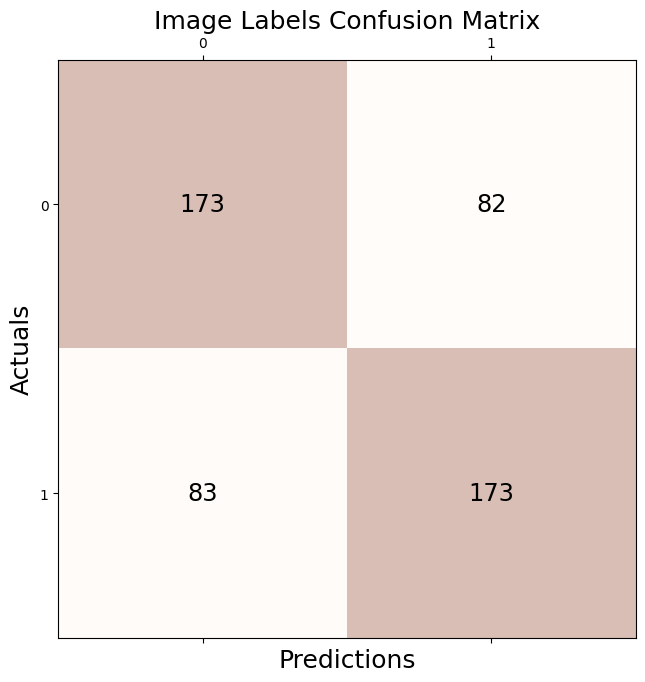

The TFID accuracy using the Labels is 0.6771


In [25]:
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Image Labels Confusion Matrix', fontsize=18)
plt.show()
acc = accuracy_score(Y,Y_pred)
print("The TFID accuracy using the Labels is",round(acc,4))


### Logistic Regression with Image Captions

In [26]:
#Logistic Regression with Image Captions
i=0

#Read file
df = pd.read_csv("Labeled Geo Data.csv")
df = df[['BinEngagementScore','description']]
df = df.rename(columns={"BinEngagementScore":"binary","description":"text"})

def remove_punctuation(s):
    no_punct = ""
    for letter in s:
        if letter not in string_punctuation:
            no_punct += letter
    return no_punct

#Read the text column---Last Column (Assumption)
string_punctuation = '''()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
stop = stopwords.words('english')
df.iloc[ :, -1] = df.iloc[ :, -1].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

for row in df['text']:
    df.iloc[ i, -1] = remove_punctuation(row)
    i=i+1
df['text'] = df['text'].str.replace("!"," !")
df['text'] = df['text'].apply(word_tokenize)
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])
df['text'] = df['text'].apply(lambda x : " ".join(x))
Text_Column = df.iloc[ :, -1:]
#Get TFIDF Scores
sklearn_tfidf = TfidfVectorizer(min_df=.01, max_df =.95, stop_words="english",use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(Text_Column.iloc[:, 0].tolist())
Tfidf_Output = pd.DataFrame(sklearn_representation.toarray(), columns=sklearn_tfidf.get_feature_names_out())

#Append the column to the final dataset
Input = pd.concat([df, Tfidf_Output], axis=1)
Input = Input.drop(['text'], axis=1)    #python changed dropping columns
# Input = Input.drop(['fit'], axis=1) #edited this out of Baruas code

#split into training: 60 and testing set: 40
train, test = train_test_split(Input, train_size = 0.6,random_state=1)
X = Input.loc[:, Input.columns != 'binary']
Y = Input['binary']
X_test = test.loc[:, Input.columns != 'binary']
Y_test = test['binary']

#Logit Regression
classifier = LogisticRegression()
classifier.fit(X, Y)
Y_pred = classifier.predict(X_test)

Y_pred = model_selection.cross_val_predict(classifier, X, Y, cv=5)

# Confusion matrix
conf_matrix = confusion_matrix((np.array(Y)), Y_pred)
conf_matrix

array([[177,  78],
       [ 62, 194]])

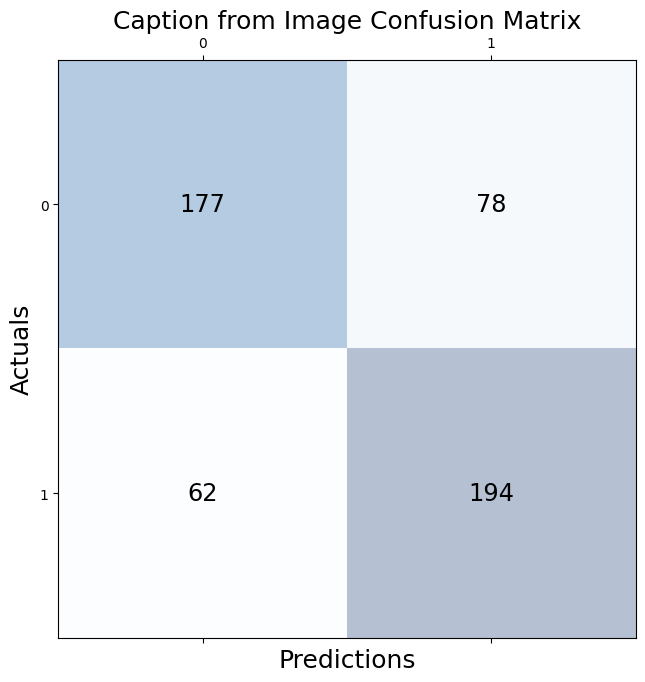

The TFID accuracy using the Captions is 0.726


In [27]:
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Caption from Image Confusion Matrix', fontsize=18)
plt.show()
acc = accuracy_score(Y,Y_pred)
print("The TFID accuracy using the Captions is",round(acc,4))

### Logistic Regression with Labeled Data + Captions

In [28]:
#Logistic Regression with Labeled Data + Captions
i=0

#Read file
df = pd.read_csv("Labeled Geo Data.csv")
df['description + labels'] = df['description'] + df['Image Labels']
df = df[['BinEngagementScore','description + labels']]
df = df.rename(columns={"BinEngagementScore":"binary","description + labels":"text"})

def remove_punctuation(s):
    no_punct = ""
    for letter in s:
        if letter not in string_punctuation:
            no_punct += letter
    return no_punct

#Read the text column---Last Column (Assumption)
string_punctuation = '''()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
stop = stopwords.words('english')
df.iloc[ :, -1] = df.iloc[ :, -1].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

for row in df['text']:
    df.iloc[ i, -1] = remove_punctuation(row)
    i=i+1
df['text'] = df['text'].str.replace("!"," !")
df['text'] = df['text'].apply(word_tokenize)
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])
df['text'] = df['text'].apply(lambda x : " ".join(x))
Text_Column = df.iloc[ :, -1:]
#Get TFIDF Scores
sklearn_tfidf = TfidfVectorizer(min_df=.01, max_df =.95, stop_words="english",use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(Text_Column.iloc[:, 0].tolist())
Tfidf_Output = pd.DataFrame(sklearn_representation.toarray(), columns=sklearn_tfidf.get_feature_names_out())

#Append the column to the final dataset
Input = pd.concat([df, Tfidf_Output], axis=1)
Input = Input.drop(['text'], axis=1)    #python changed dropping columns
# Input = Input.drop(['fit'], axis=1) #edited this out of Baruas code

#split into training: 60 and testing set: 40
train, test = train_test_split(Input, train_size = 0.6,random_state=1)
X = Input.loc[:, Input.columns != 'binary']
Y = Input['binary']
X_test = test.loc[:, Input.columns != 'binary']
Y_test = test['binary']

#Logit Regression
classifier = LogisticRegression()
classifier.fit(X, Y)
Y_pred = classifier.predict(X_test)

Y_pred = model_selection.cross_val_predict(classifier, X, Y, cv=5)

# Confusion matrix
conf_matrix = confusion_matrix((np.array(Y)), Y_pred)
conf_matrix

array([[183,  72],
       [ 65, 191]])

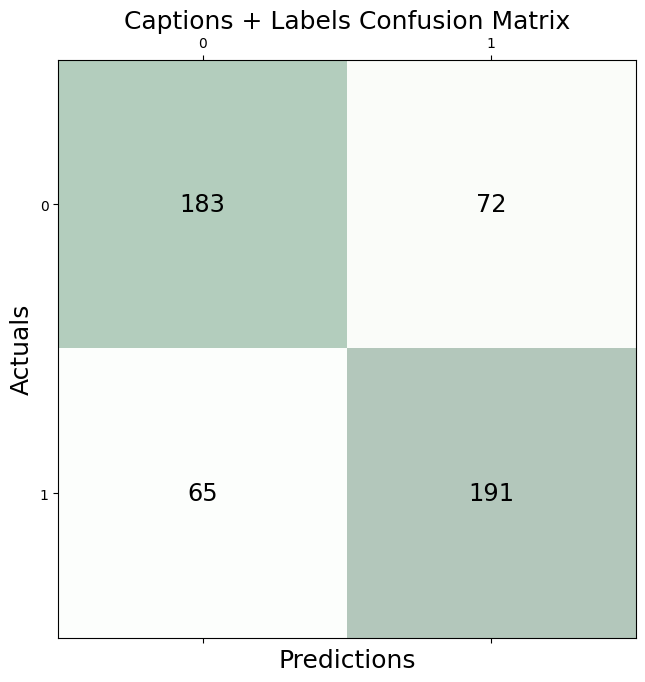

The TFID accuracy using the Combined Captions and Labels is 0.7319


In [29]:
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Captions + Labels Confusion Matrix', fontsize=18)
plt.show()
acc = accuracy_score(Y,Y_pred)
print("The TFID accuracy using the Combined Captions and Labels is",round(acc,4))

<strong> Regression Assessment </strong>
</br>
Looking at the accuracies of the different logistic regressions that are using Image Captions, Image Labels, and the combinations of both, image labels get a higher accuracy than just the post captions. Using image labels by themselves are great because they use Google Vision and Google's machine learning models that are fed billions of images and perhaps more to create very accurate models to classify images. Using a combination of both labels and Image Captions gets a higher accuracy than the others by themselves. It would be beneficial for NatGeo to use both Image captions and post descriptions to optimize and increase the accuracy of the Logistic Regression for predicting high engagement posts.

## Task C - Topic Modeling

### Topic Modeling

In [3]:
# Downloading packages from NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/domitillechambon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/domitillechambon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/domitillechambon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Read in labeled data
labelData = pd.read_csv("Labeled Geo Data.csv")
labelData["id"] = range(1, len(labelData) + 1)

# Creating reviews_df dataframe
reviews_df = labelData[["id", "Image Labels"]]
reviews_df = reviews_df.rename(columns= {"id": "id", "Image Labels": "Labels"})

In [5]:
#checking for nulls if present any
print("Number of rows with any of the empty columns:")
print(reviews_df.isnull().sum().sum())
reviews_df=reviews_df.dropna()

Number of rows with any of the empty columns:
0


In [6]:
# Variables for two column names and number of topics
restaurant_name = "id"
restaurant_review = "Labels"
ntopics= 5

In [7]:
# Actualizing functions
word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))

In [8]:
# Function that tokenizes the text
def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens

In [9]:
# Word to Vec variable created and total number of feeatures and words
vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords_nltk,decode_error='ignore')
total_features_words = vec_words.fit_transform(reviews_df[restaurant_review])

print(total_features_words.shape)

(511, 817)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [10]:
# Actualizing the model
model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)

INFO:lda:n_documents: 511
INFO:lda:vocab_size: 817
INFO:lda:n_words: 6257
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -56040
INFO:lda:<10> log likelihood: -39137
INFO:lda:<20> log likelihood: -37919
INFO:lda:<30> log likelihood: -37252
INFO:lda:<40> log likelihood: -36838
INFO:lda:<50> log likelihood: -36720
INFO:lda:<60> log likelihood: -36733
INFO:lda:<70> log likelihood: -36755
INFO:lda:<80> log likelihood: -36585
INFO:lda:<90> log likelihood: -36534
INFO:lda:<100> log likelihood: -36420
INFO:lda:<110> log likelihood: -36300
INFO:lda:<120> log likelihood: -36428
INFO:lda:<130> log likelihood: -36369
INFO:lda:<140> log likelihood: -36295
INFO:lda:<150> log likelihood: -36335
INFO:lda:<160> log likelihood: -36346
INFO:lda:<170> log likelihood: -36369
INFO:lda:<180> log likelihood: -36372
INFO:lda:<190> log likelihood: -36300
INFO:lda:<200> log likelihood: -36242
INFO:lda:<210> log likelihood: -36199
INFO:lda:<220> log likelihood: -36181
INFO:lda:<230> log li

In [11]:
topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
reviews_df=reviews_df.join(doc_topic)
restaurant=pd.DataFrame()

In [12]:
for i in range(int(ntopics)):
    topic="topic_"+str(i)
    restaurant[topic]=reviews_df.groupby([restaurant_name])[i].mean()

In [13]:
restaurant=restaurant.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
print ("Topics word distribution written in file topic_word_dist.csv ")
topics1.to_csv("topic_word_dist.csv")
restaurant.to_csv("document_topic_dist.csv",index=False)
print ("Document topic distribution written in file document_topic_dist.csv ")

Topics word distribution written in file topic_word_dist.csv 
Document topic distribution written in file document_topic_dist.csv 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Quartile & Topic Weights

In [14]:
# Finding first and third quartiles
print("First quartile:", labelData.EngagementScore.quantile([.25]))
print("Third quartile:", labelData.EngagementScore.quantile([.75]))

First quartile: 0.25    0.044681
Name: EngagementScore, dtype: float64
Third quartile: 0.75    0.092231
Name: EngagementScore, dtype: float64


In [15]:
# Setting first and third quartile scores
firstQuartile = float(.044681)
thirdQuartile = float(.092231)

# Dataframe with values from first and third quartiles
dfQuartile = labelData[(labelData["EngagementScore"] <= firstQuartile) | (labelData["EngagementScore"] >= thirdQuartile)]

In [16]:
# Identifying quartile
def quart(val):
    """ Determine which quartile the image belongs to"""
    if val >= thirdQuartile:
        return "third"
    elif val <= firstQuartile:
        return "first"

In [17]:
# Labeling first or third quartile
dfQuartile["Quartile"] = dfQuartile["EngagementScore"].apply(lambda x: quart(x))

# Excluding unnecessary columns from dataframe
dfQuartile = dfQuartile[["id", "Quartile", "EngagementScore", "BinEngagementScore", "Image Labels"]]

/var/folders/s5/8fq8vkds1wschn5rrzxkc8br0000gn/T/ipykernel_51279/3580295398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfQuartile["Quartile"] = dfQuartile["EngagementScore"].apply(lambda x: quart(x))


In [18]:
# Reading in topic modeling csv
topicModels = pd.read_csv("document_topic_dist.csv")

# List of IDs in quartile dataframe
quartileIDlist = list(dfQuartile["id"])

# Removing rows that aren't in ID list
topicModels = topicModels[topicModels["id"].isin(quartileIDlist)]

# Concatenating two dataframes
dfComb = pd.concat([dfQuartile, topicModels], axis= 1)

# Removing unnecessary columns
dfComb = dfComb[["Quartile", "topic_0", "topic_1", "topic_2", "topic_3", "topic_4"]]

In [19]:
# Averaging topic values and grouping by first and third quartile
dfAverage = dfComb.groupby("Quartile").mean()

In [20]:
# Average topic values per 2 quartiles pre topic naming
dfAverage

,topic_0,topic_1,topic_2,topic_3,topic_4
Quartile,,,,,
first,0.250614,0.308500,0.230378,0.171797,0.038711
third,0.179272,0.076586,0.184044,0.271103,0.288995


In [30]:
# Renaming topics to believed categories
dfAverage = dfAverage.rename(columns= {"topic_0": "Wedding", "topic_1": "Car Garage", "topic_2": "Mountain Range/Glacier", "topic_3": "Forest & Sky", "topic_4": "Big Cats"})

In [31]:
# Average topic values per 2 quartiles post topic naming
dfAverage

,Wedding,Car Garage,Mountain Range/Glacier,Forest & Sky,Big Cats
Quartile,,,,,
first,0.250614,0.308500,0.230378,0.171797,0.038711
third,0.179272,0.076586,0.184044,0.271103,0.288995


<strong> Topic Value Assessment </strong>
</br>
There are two significant differences between the two quartiles in regard to the following topics: Car Garage (Topic_1) and Big Cats (Topic_4). The Big Cats topic has a greater proportion in the third quartile (the highest engagement quartile); whereas, the inverse is true for Car Garage, where there is a greater proportion in the first quartile (the lower engagement quartile). There is also a marginally higher proportion of Forest & Sky (Topic_3) in third quartile. Wedding (Topic_0) and Mountain Range/Glacier (Topic_2) have slightly higher proportions in the first quartile.

## Task D - Analysis